# importing json file


import json per la llibreria que treballa amb json

In [1]:
import json
import numpy as np #aqui hi ha les estructures de dades que faig servir
import matplotlib.pyplot as plt #per dibuixar
import scipy.io as sio #el input output d'audio (wavfile.read)
from IPython.display import Audio #el reproductor d'audio
from numpy.fft import fft, ifft #podria fer numpy.fft en comptes de fer aquest import
from wav2vec import cutvowel, wav2vec #el nostre modul

importo el meu fitxer json

In [2]:
with open("./vowels/jordi.json") as f:
    data = json.load(f)
print(data[30])

{'vocal': 'i', 'start': '5.64', 'end': '5.69'}


In [3]:
start = data[30]["start"]
end = data[30]["end"]
print(float(start))

5.64


les llibreries que necesito per utilitzar i processar audio

carrego el fitxer d'audio

In [4]:
select = 5 #5 i 103
start = float(data[select]["start"])
end=float(data[select]["end"])

print(data[select], start, end)

Fs, audio = sio.wavfile.read("./vowels/jordi.wav")
#Fs, audio = cutvowel("vowels/alex.wav"), float(data[select]["start"]), float(data[select]["end"]))
print(Fs, int(start*Fs), int(end*Fs), len(audio))
cut = audio[int(start*Fs):int(end*Fs)]

#print(Fs)
#print(len(audio)) #per mirar si és estero o mono
#print(type(audio))
#print(type(audio[0]))

#start=4.4 #realment ho agafariem del fitxer json
#end=4.6

#framesentrada = int(float(start)*Fs) #calculem la mostra d'entrada
#framesalida = int(float(end)*Fs)
#cut=audio[framesentrada:framesalida] #retallem

#cut = audio
#data[select]["vocal"]
print(Fs)
print(cut)
print(len(cut))

{'vocal': 'a', 'start': '1.37', 'end': '1.42'} 1.37 1.42
44100 60417 62622 1211392
44100
[ 7104  6205  5371 ... -2895 -2840 -2810]
2205


In [5]:
Audio(cut, rate=Fs)

In [6]:
def mostra2Freq(n_mostra, Fs, mostras_totals):
    return n_mostra * Fs / mostras_totals

def freq2Mostra(freq, Fs, mostras_totals):
    return freq * mostras_totals / Fs

dibuixem l'audio retallat

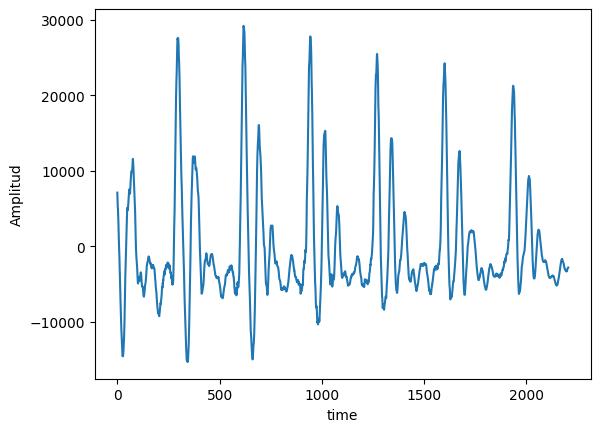

In [7]:
plt.figure()
plt.plot(cut)
plt.title("")
plt.xlabel("time")
plt.ylabel("Amplitud")
plt.show()

Dificil entendre algo. mirem fourier

/home/iticbnc/Documentos/course/ai/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/iticbnc/Documentos/course/ai/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


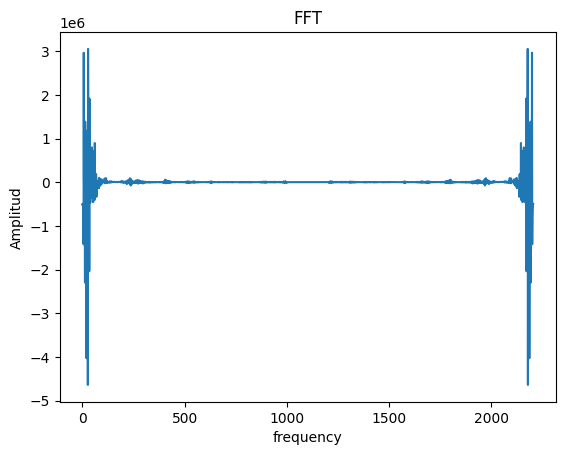

In [8]:
fourier = fft(cut)
plt.figure()
plt.plot(fourier)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("Amplitud")
plt.show()

només m'importa el que pasa a prop de zero

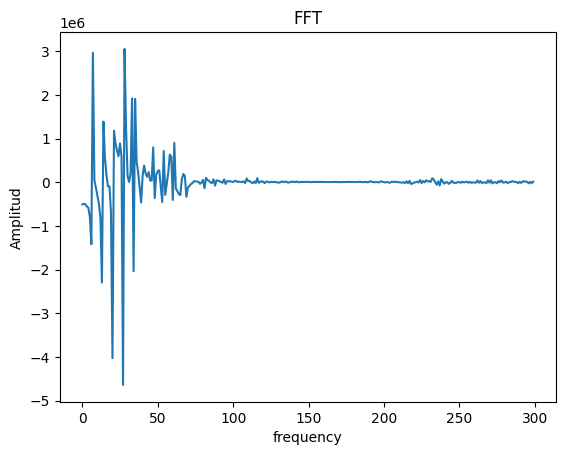

In [9]:
Fsmall = fourier[0:300]
plt.figure()
plt.plot(Fsmall)
plt.title("FFT")
plt.xlabel("frequency")
plt.ylabel("Amplitud")
plt.show()

No m'importa la fase, només el módul.


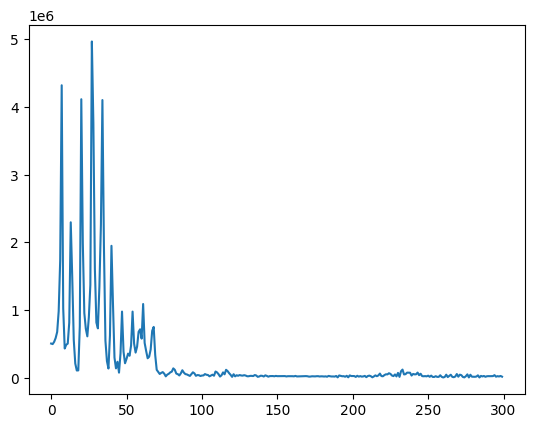

In [10]:
toprocess = np.sqrt((np.real(Fsmall)**2+np.imag(Fsmall)**2))
plt.figure()
plt.plot(toprocess)
plt.show()

Aplico un filtre per quedar eliminar soroll

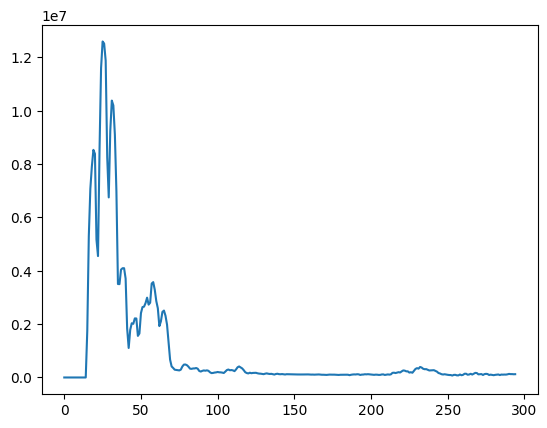

25

In [11]:
filter = 5
out = np.zeros(len(toprocess)-filter, dtype=np.float64)
for i in range(len(toprocess)-filter):
    for j in range(filter):
        out[i] += toprocess[i+j]

        
out[0:15] = 0
        
plt.figure()
plt.plot(out)
plt.show()

np.argmax(out)

25


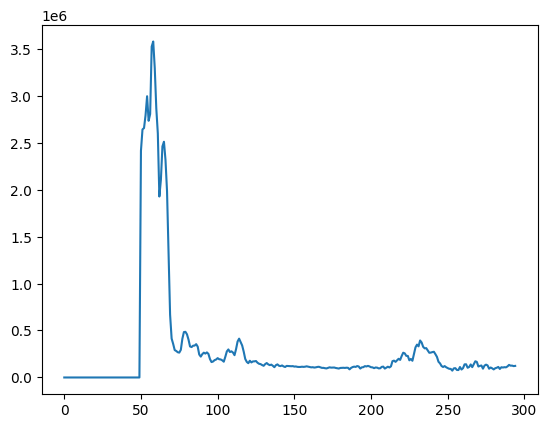

58


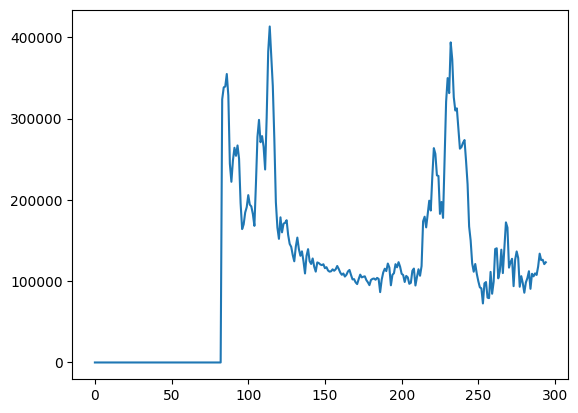

114


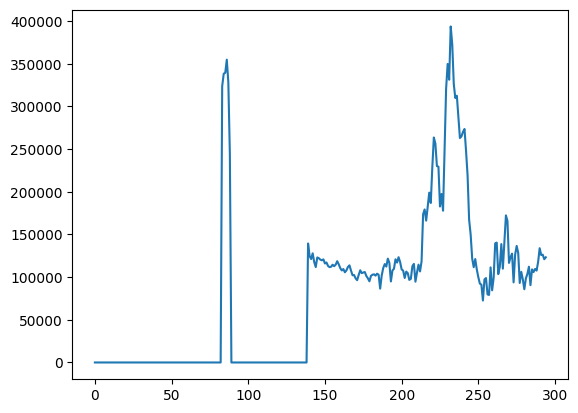

In [12]:
filter2 = 25

maxim1 = np.argmax(out)
print(maxim1)

filmin = filter2
if maxim1 < filter2:
    filmin = maxim1

out[maxim1-filmin:maxim1+filter2] = 0
plt.figure()
plt.plot(out)
plt.show()

maxim2 = np.argmax(out)
print(maxim2)

out[maxim2-filter2:maxim2+filter2] = 0
plt.figure()
plt.plot(out)
plt.show()


maxim3 = np.argmax(out)
print(maxim3)

out[maxim3-filter2:maxim3+filter2] = 0
plt.figure()
plt.plot(out)
plt.show()

In [13]:
print(fourier.size)
print(Fs)
print((maxim1)*Fs/fourier.size, "Hz")
print((maxim2)*Fs/fourier.size, "Hz")
print((maxim3)*Fs/fourier.size, "Hz")

2205
44100
500.0 Hz
1160.0 Hz
2280.0 Hz


## SVM con filtro

In [14]:
with open("./vowels/jordi.json") as f:
    data = json.load(f)

Fs, audio = sio.wavfile.read("./vowels/jordi.wav")
result = []
dataset = None
vowelsValue = {
    'a': 1,
    'e': 2,
    'i': 3,
    'o': 4,
    'u': 5
}

for index, item in enumerate(data):
    start = float(item['start'])
    end = float(item['end'])

    if (end - start) < 0.04:
        # Ignore short vowels
        continue

    cut = audio[int(start*Fs):int(end*Fs)]
    fourier = fft(cut)
    Fsmall = fourier[0:300]
    toprocess = np.sqrt((np.real(Fsmall)**2+np.imag(Fsmall)**2))

    filter = 5
    out = np.zeros(len(toprocess)-filter, dtype=np.float64)
    for i in range(len(toprocess)-filter):
        for j in range(filter):
            out[i] += toprocess[i+j]

    out[0:15] = 0

    filter2 = 25
    maxim1 = np.argmax(out)

    filmin = filter2
    if maxim1 < filter2:
        filmin = maxim1

    out[maxim1-filmin:maxim1+filter2] = 0
    maxim2 = np.argmax(out)

    out[maxim2-filter2:maxim2+filter2] = 0
    maxim3 = np.argmax(out)

    out[maxim3-filter2:maxim3+filter2] = 0

    size1 = int((maxim1)*Fs/fourier.size)
    size2 = int((maxim2)*Fs/fourier.size)
    size3 = int((maxim3)*Fs/fourier.size)

    result.append({ 'index': index, 'vowel': item['vocal'], 'length': f"{end - start:0.3f}", 'size1': size1, 'size2': size2, 'size3': size3 })
    newArr = np.array([size1, size2, size3, vowelsValue[item['vocal']]])

    if dataset is None:
        dataset = np.array([newArr], dtype=np.int32)
    else:
        dataset = np.vstack((dataset, np.array([newArr])))

def sortResult(e):
    return e['vowel']

result.sort(key=sortResult)

X = dataset[:, :2]
y = dataset[:, 3:4].flatten()

0.43243243243243246


/home/iticbnc/Documentos/course/ai/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


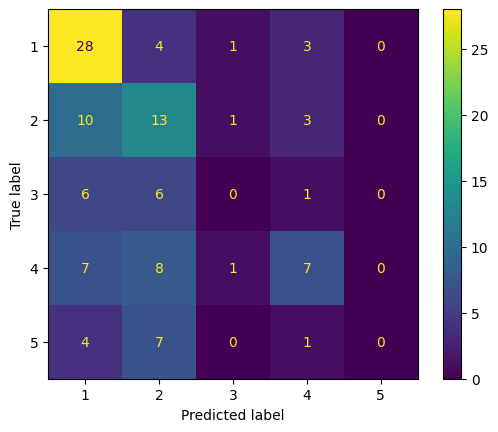

In [15]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y,

stratify=y, test_size=0.7, random_state=42)

classifier= LogisticRegression().fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(nca_pipe, X_test, y_test)


In [16]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

C = 1.0  # SVM regularization parameter
models = [
    svm.SVC(kernel='linear'),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    # svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)


0.4594594594594595
0.43243243243243246
0.18018018018018017


## SVM con menos calidad de audio

In [17]:
with open("./vowels/jordi.json") as f:
    data = json.load(f)

Fs, audio = sio.wavfile.read("./vowels/jordi.wav")
result = []
datasetX = None
datasetY = None
vowelsValue = {
    'a': 1,
    'e': 2,
    'i': 3,
    'o': 4,
    'u': 5
}

def resize_fft(ftt_audio, muestras, cut_frequency):
    y = np.zeros(muestras)
    sample_rate = int(cut_frequency/muestras)
    sample_to_take = int(sample_rate*len(ftt_audio)/cut_frequency)

    for i in range(muestras):
        for j in range(sample_to_take):
            y[i] += ftt_audio[i*sample_to_take+j]

    return y

for index, item in enumerate(data):
    start = float(item['start'])
    end = float(item['end'])

    if (end - start) < 0.04:
        # Ignore short vowels
        continue

    cut = audio[int(start*Fs):int(end*Fs)]
    fourier = fft(cut)
    Fsmall = fourier[0:300]
    toprocess = np.sqrt((np.real(Fsmall)**2+np.imag(Fsmall)**2))

    # plt.figure()
    # plt.plot(toprocess)
    # plt.show()

    resizedToprocess = resize_fft(toprocess, 100, 3000)

    # plt.figure()
    # plt.plot(resizedToprocess)
    # plt.show()

    newArr = np.array(resizedToprocess, dtype=np.float32)

    if datasetX is None:
        datasetX = np.array([newArr], dtype=np.float32)
    else:
        datasetX = np.vstack((datasetX, np.array([newArr])))

    if datasetY is None:
        datasetY = item['vocal']
    else:
        datasetY = np.append(datasetY, item['vocal'])

0.43243243243243246


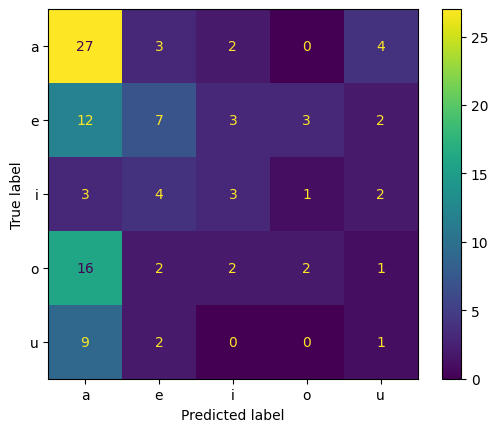

In [73]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis, KNeighborsClassifier)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, stratify=y, test_size=0.7, random_state=35)

classifier= LogisticRegression().fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(nca_pipe, X_test, y_test)

In [19]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.7, random_state=42)

C = 1.0  # SVM regularization parameter
models = [
    svm.SVC(kernel='linear'),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)


0.2972972972972973
0.3333333333333333
0.17117117117117117
0.25225225225225223


/home/iticbnc/Documentos/course/ai/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
